In [1]:
%matplotlib inline

import os
import glob
import numpy as np
from numpy.fft import fft, ifft, fftfreq
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.animation import FuncAnimation
import seaborn as sns
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import isc, isfc, isps, fdr, threshold, phase_randomize, circle_shift, _butter_bandpass_filter, _phase_mean_angle, _phase_vector_length
from nilearn.plotting import view_img_on_surf, view_img
from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state
from scipy.stats import ttest_1samp
from scipy.stats import ttest_rel
from scipy.signal import hilbert
import networkx as nx
from IPython.display import HTML

import subprocess
import pickle
from datetime import datetime
from time import time
import pdb

/Users/gracer/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/gracer/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
def adillyofapickle(basepath,dic, name):
    datefmt='%m-%d-%Y_%I-%M-%S'
    st = datetime.fromtimestamp(time()).strftime(datefmt)
    if os.path.exists(os.path.join(basepath,'tmp')):
        print('already have tmp')
    else:
        os.makedirs(os.path.join(basepath,'tmp'))
    pickle.dump(dic, open(os.path.join(basepath,'tmp','%s_%s'%(name,st)), 'wb'), protocol=4)


In [376]:
def onetoughjar(p):
    list_of_files = glob.glob(p) # * means all if need specific format then *.csv
    latest_file = max(list_of_files, key=os.path.getmtime)
    print(latest_file)
    with open(latest_file, 'rb') as pickle_file:
        try:
            while True:
                output = pickle.load(pickle_file)
        except EOFError:
            pass
    return(output)

In [4]:
def get_subject_roi(data_dict, roi_num):
    sub_rois = {}
    for sub, value in data_dict.items():
        sub_rois[sub] = value[ROIS['0'].iloc[10]]
    return pd.DataFrame(sub_rois)

## Re runs
For some reason 116 and 117 wouldn't work on renci. Ran locally below... oops these don't exist!

In [6]:
homepath = '/Users/gracer/OneDrive - University of Wyoming/0. Lab/M2AENAD Lab - Documents/RESEARCH/BRO/scripts'
datapath = '/Users/gracer/OneDrive - University of Wyoming/0. Lab/M2AENAD Lab - Documents/RESEARCH/BRO/data/BRO_isc/tmp'
maskpath = '/Users/gracer/OneDrive - University of Wyoming/0. Lab/M2AENAD Lab - Documents/RESEARCH/BRO/data/atlas'

In [377]:
tim = onetoughjar(os.path.join(datapath,'time*'))

/Users/gracer/OneDrive - University of Wyoming/0. Lab/M2AENAD Lab - Documents/RESEARCH/BRO/data/BRO_isc/tmp/timeseries_parc_03-09-2023_01-13-01


In [380]:
tim['BRO']['run-1'].keys()

dict_keys(['sub-007', 'sub-009', 'sub-020', 'sub-011', 'sub-004', 'sub-022', 'sub-013', 'sub-025', 'sub-023', 'sub-029', 'sub-038', 'sub-036', 'sub-047', 'sub-043', 'sub-051', 'sub-001', 'sub-027'])

In [381]:
tim['BRO']['run-2'].keys()

dict_keys(['sub-038', 'sub-036', 'sub-043', 'sub-009', 'sub-007', 'sub-004', 'sub-022', 'sub-047', 'sub-023', 'sub-051', 'sub-025', 'sub-013', 'sub-029', 'sub-011', 'sub-027', 'sub-001'])

In [32]:
subs = list(tim['BRO']['run-1'].keys())

In [ ]:
list(tim['BRO']['run-1']['sub-047'].columns)

In [ ]:
# test = get_subject_roi(tim['BRO']['run-1'], 116)

In [ ]:
# # condition = 'BRO'
# # ROI = 117
# df = pd.concat([get_subject_roi(tim[condition]['run-1'], ROI), get_subject_roi(tim[condition]['run-2'], ROI)], ignore_index=True)
# inp = df.dropna(axis=1)
# stats = isc(inp, n_bootstraps=5000, metric='median', method='%s'%('circle_shift'), return_bootstraps = True)
# packit = {'%s'%condition:{'%s_ROI'%ROI:{'stats':stats, 'df':inp,'method':'circle_shift'}}}

# adillyofapickle(datapath,packit, '%s_%s_%s'%(condition,ROI,'circle_shift'))


In [ ]:
ROIS = pd.read_csv(os.path.join(datapath,'ROIS.csv'))

In [ ]:
results_circle = {}
for x in range(0,118):
    PLA = 'PLA_%s_circle*'%x
    BRO = 'BRO_%s_circle*'%x
    try:
        results_circle.update({
         x:{'PLA':onetoughjar(os.path.join(datapath,PLA)),
            'BRO': onetoughjar(os.path.join(datapath,BRO))}})    
    except ValueError:
        print(x)

                    

In [ ]:
results_circle.keys()

## make dataframe

In [ ]:
d = {'cond': [], 'ROI': [], 'isc':[], 'p':[], 'ci-':[],'ci+':[]}
for ROI, item in results_circle.items():
    for cond, data in item.items():
        d['ROI'].append(ROI)
        d['cond'].append(cond)
        d['isc'].append(data[cond]['%s_ROI'%ROI]['stats']['isc'])
        d['p'].append(data[cond]['%s_ROI'%ROI]['stats']['p'])
        d['ci-'].append(data[cond]['%s_ROI'%ROI]['stats']['ci'][0])
        d['ci+'].append(data[cond]['%s_ROI'%ROI]['stats']['ci'][1])
df = pd.DataFrame(data=d)

In [ ]:
df.to_csv(os.path.join(datapath,'circle.csv'), sep = ',')

In [ ]:
ttest_rel(rvs1, rvs3)

# Behavioral similarity analysis

In [388]:
pla_subs = tim['PLA']['run-1'].keys()
bro_subs = tim['BRO']['run-1'].keys()

In [389]:
pla_subs

dict_keys(['sub-008', 'sub-003', 'sub-012', 'sub-010', 'sub-044', 'sub-052', 'sub-016', 'sub-026', 'sub-035', 'sub-039', 'sub-017', 'sub-030', 'sub-046', 'sub-033', 'sub-040', 'sub-028', 'sub-019', 'sub-053', 'sub-045', 'sub-032', 'sub-041', 'sub-002'])

In [299]:
intake_data = pd.read_csv(os.path.join(os.path.join(datapath,'intake_data.csv')), sep=',')


In [300]:
intake_data = intake_data[intake_data['diff_milk'].notna()]

In [301]:
path2beh = 'bro_behav.csv'
behav = pd.read_csv(os.path.join(datapath,path2beh))
behav2 = behav.set_index('participantID')

In [384]:
behav2

,order,drug_v1,drug_v2,pre_date,pre_ID,pre_height1,pre_height2,pre_weight1,pre_weight2,pre_bmiqcheck,...,dordesire_1_v1,dorsavory_1_v1,dorintense_1_v1,Finished_v2,logo1pleasant_1_v2,logo2pleasant_1_v2,milkshakepleasant_1_v2,milkshakedesire_1_v2,milkshakesweet_1_v2,milkshakeintense_1_v2
participantID,,,,,,,,,,,,,,,,,,,,,
sub-001,AB,active,placebo,9/19/17,pre_bro071,166.6,167.0,91.4,91.4,Qualify,...,66.0,-69.0,53.0,True,41.0,-56.0,21.0,-73.0,46.0,48.0
sub-002,BA,placebo,active,9/20/17,pre_bro022,167.5,167.6,87.7,87.7,Qualify,...,38.0,27.0,48.0,True,38.0,-34.0,29.0,3.0,81.0,51.0
sub-003,BA,placebo,active,9/20/17,pre_bro028,160.5,161.0,63.9,63.9,Qualify,...,68.0,57.0,78.0,True,41.0,9.0,37.0,37.0,41.0,47.0
sub-004,AB,active,placebo,9/20/17,pre_bro038,166.6,166.6,80.9,80.9,Qualify,...,38.0,26.0,30.0,True,-20.0,15.0,43.0,38.0,40.0,47.0
sub-006,BA,placebo,active,9/21/17,pre_bro021,170.5,171.0,73.4,73.4,Qualify,...,24.0,43.0,35.0,True,-11.0,7.0,11.0,-72.0,46.0,74.0
sub-007,AB,active,placebo,9/21/17,pre_bro025,163.8,164.5,72.8,72.7,Qualify,...,42.0,48.0,44.0,True,46.0,-15.0,-16.0,-98.0,42.0,68.0
sub-008,BA,placebo,active,9/22/17,pre_bro009,165.1,164.6,70.9,70.9,Qualify,...,78.0,74.0,85.0,True,21.0,20.0,17.0,-10.0,47.0,59.0
sub-009,AB,active,placebo,9/24/17,pre_bro004,181.5,182.1,87.3,87.3,Qualify,...,21.0,19.0,54.0,True,31.0,43.0,36.0,24.0,17.0,30.0
sub-010,BA,placebo,active,9/24/17,pre_bro089,183.4,183.4,98.9,98.9,Qualify,...,100.0,43.0,65.0,True,19.0,-15.0,21.0,-1.0,41.0,48.0


In [395]:
sumsum = behav2[behav2.index.isin(pla_subs)]

In [400]:
sumsum['BMI'].std() 

2.506966196012336

In [304]:
pla_new = {'participantID':[],'condition':[],'diff_milk':[]}

for sub in list(pla_subs):
    print(sub)
    if behav2.loc[sub,'drug_v1'] == 'placebo':
        milk = intake_data[(intake_data['participantID'] == '%s'%sub )& (intake_data['testwave']=='ses-1')]['diff_milk']
        try:
            pla_new['diff_milk'].append(milk.values[0])
            pla_new['participantID'].append(sub)
            pla_new['condition'].append('ses-2')
        except IndexError:
            print('skip')
    else:
        milk = intake_data[(intake_data['participantID'] == '%s'%sub )& (intake_data['testwave']=='ses-2')]['diff_milk']
        try:
            pla_new['diff_milk'].append(milk.values[0])
            pla_new['participantID'].append(sub)
            pla_new['condition'].append('ses-1')
        except IndexError:
            print('skip')
        
        

sub-008
sub-003
sub-012
sub-010
sub-044
sub-052
sub-016
sub-026
sub-035
sub-039
sub-017
sub-030
sub-046
sub-033
sub-040
sub-028
sub-019
sub-053
sub-045
sub-032
sub-041
sub-002


In [305]:
bro_new = {'participantID':[],'condition':[],'diff_milk':[]}

for sub in list(bro_subs):
    print(sub)
    if behav2.loc[sub,'drug_v1'] == 'brocebo':
        milk = intake_data[(intake_data['participantID'] == '%s'%sub )& (intake_data['testwave']=='ses-1')]['diff_milk']
        try:
            bro_new['diff_milk'].append(milk.values[0])
            bro_new['participantID'].append(sub)
            bro_new['condition'].append('ses-2')
        except IndexError:
            print('skip')
    else:
        milk = intake_data[(intake_data['participantID'] == '%s'%sub )& (intake_data['testwave']=='ses-2')]['diff_milk']
        try:
            bro_new['diff_milk'].append(milk.values[0])
            bro_new['participantID'].append(sub)
            bro_new['condition'].append('ses-1')
        except IndexError:
            print('skip')

sub-007
sub-009
sub-020
skip
sub-011
sub-004
sub-022
sub-013
sub-025
sub-023
sub-029
sub-038
sub-036
sub-047
sub-043
sub-051
sub-001
sub-027


In [306]:
bro_new = pd.DataFrame.from_dict(bro_new)
pla_new = pd.DataFrame.from_dict(pla_new)

/Users/gracer/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/gracer/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='diff_milk', ylabel='Density'>

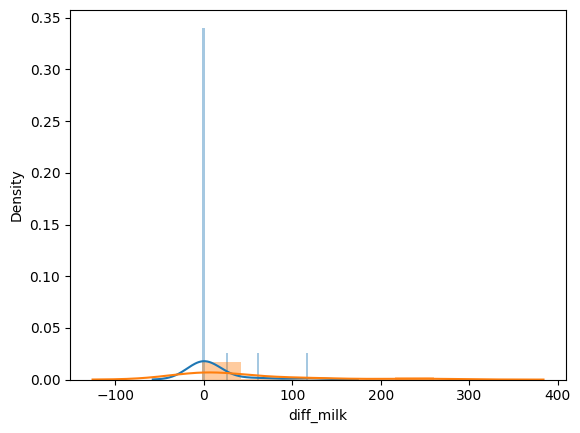

In [307]:
bro_behav = bro_new["diff_milk"]
pla_behav = pla_new["diff_milk"]
sns.distplot(bro_behav)
sns.distplot(pla_behav)

In [85]:
from scipy.stats import rankdata, ttest_rel, ttest_1samp


/Users/gracer/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

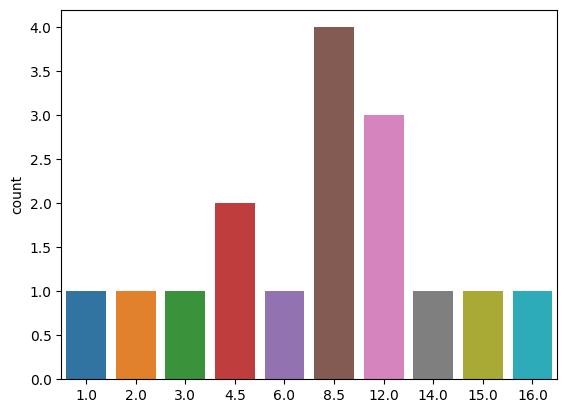

In [383]:
bro_behav_rank = rankdata(bro_behav)
pla_behav_rank = rankdata(pla_behav)
# sns.countplot(pla_behav_rank)
sns.countplot(bro_behav_rank)

In [309]:
# subj_list = behav_data["participant_id"]

pladata = []
for sub in list(tim['PLA']['run-1'].keys()):
#     print(sub)
    sub_data = []
    for run in range(1,2):
        df = tim['PLA']['run-%s'%run][sub]
#         print(df)
        sub_data.append(df)
    sub_data = pd.concat(sub_data)
    if sub_data.values.shape == (193, 116):
        pladata.append(sub_data.values)
    else:
        print(sub)


In [310]:
# subj_list = behav_data["participant_id"]

brodata = []
for sub in subs:
#     print(sub)
    sub_data = []
    for run in range(1,2):
        df = tim['BRO']['run-%s'%run][sub]
#         print(df)
        sub_data.append(df)
    sub_data = pd.concat(sub_data)
    if sub_data.values.shape == (193, 116):
        brodata.append(sub_data.values)
    else:
        print(sub)




sub-020


In [312]:
bro_data = np.array(brodata)

In [313]:
pla_data = np.array(pladata)

In [314]:
pla_data.shape

(22, 193, 116)

In [315]:
bro_data.shape

(16, 193, 116)

In [316]:
bro_subs, bro_ts, bro_nodes = bro_data.shape
pla_subs, pla_ts, pla_nodes = pla_data.shape

In [317]:
pla_similarity_matrices = []
for node in range(n_nodes):
    pla_similarity_matrices.append(Adjacency(1 - pairwise_distances(pla_data[:, :, node], metric='correlation'), matrix_type='similarity'))
pla_similarity_matrices = Adjacency(pla_similarity_matrices)


In [318]:
bro_similarity_matrices = []
for node in range(n_nodes):
    bro_similarity_matrices.append(Adjacency(1 - pairwise_distances(bro_data[:, :, node], metric='correlation'), matrix_type='similarity'))
bro_similarity_matrices = Adjacency(bro_similarity_matrices)


In [321]:
pla_isc = {node:pla_similarity_matrices[node].isc(metric='median', n_bootstraps=100, n_jobs=1)['isc'] for node in range(n_nodes)}








In [322]:
bro_isc = {node:similarity_matrices[node].isc(metric='median', n_bootstraps=100, n_jobs=1)['isc'] for node in range(n_nodes)}








In [323]:
# Define some helper functions
def sort_square_mtx(mtx, vct):
    """
    Sorts rows/columns of a matrix according to a separate vector.
    """
    
    inds = vct.argsort()
    mtx_sorted = mtx.copy()
    mtx_sorted = mtx_sorted[inds, :]
    mtx_sorted = mtx_sorted[:, inds]
    
    return mtx_sorted

def scale_mtx(mtx):
    """
    Scales a matrix to have values between 0 and 1.
    """
    return (mtx-np.min(mtx))/(np.max(mtx)-np.min(mtx))

/Users/gracer/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/gracer/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/gracer/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/gracer/opt/anaconda3/lib/python3.8/site-pac

In [324]:
pla_behav_sim_nn = Adjacency(pairwise_distances(np.reshape(pla_behav_rank, (-1, 1)), metric='euclidean'), matrix_type='distance')

pla_behav_sim_nn = pla_behav_sim_nn.distance_to_similarity()



In [325]:
bro_behav_sim_nn = Adjacency(pairwise_distances(np.reshape(bro_behav_rank, (-1, 1)), metric='euclidean'), matrix_type='distance')

bro_behav_sim_nn = bro_behav_sim_nn.distance_to_similarity()



In [326]:
mask = Brain_Data(os.path.join(maskpath, 'tpl-MNI152NLin2009cAsym_res-01_atlas-HOCPAL_desc-th0_dseg.nii.gz'))
mask_x = expand_mask(mask)


In [328]:
pla_isrsa_nn = {}
for node in range(len(pla_similarity_matrices)):
    pla_isrsa_nn[node] = pla_similarity_matrices[node].similarity(pla_behav_sim_nn, metric='spearman', n_permute=1, n_jobs=1 )['correlation']


In [330]:
bro_isrsa_nn = {}
for node in range(len(bro_similarity_matrices)):
    bro_isrsa_nn[node] = bro_similarity_matrices[node].similarity(behav_sim_nn, metric='spearman', n_permute=1, n_jobs=1 )['correlation']


In [230]:
from nilearn.plotting import plot_glass_brain, plot_stat_map, view_img, view_img_on_surf


t=12.32, p = 0.000


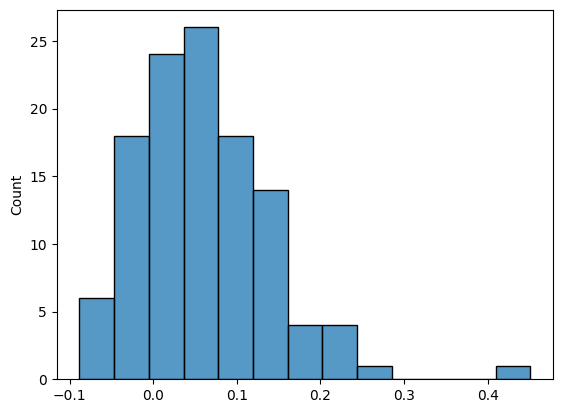

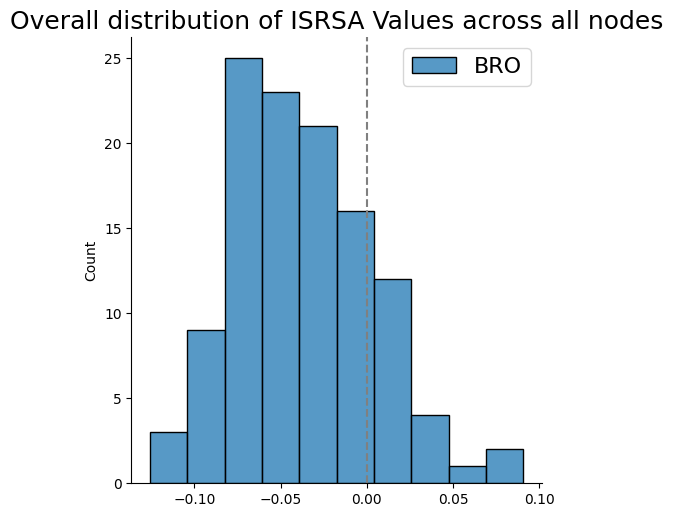

In [348]:
sns.histplot(list(bro_isrsa_nn.values()))
sns.displot(list(pla_isrsa_nn.values()))
plt.legend(['BRO', 'PLA'], fontsize=16)
plt.title('Overall distribution of ISRSA Values across all nodes', fontsize=18)
plt.gca().axvline(0, color='gray', linestyle='--');

t, p = ttest_rel(list(isrsa_nn.values()), list(pla_isrsa_nn.values()))
print(f't={t:.2f}, p = {p:.03f}')


In [343]:
bro_isrsa_nn_r, bro_isrsa_nn_p = {}, {}
pla_isrsa_nn_r, pla_isrsa_nn_p = {}, {}

for node in range(len(bro_similarity_matrices)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(bro_similarity_matrices)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    bro_stats_nn = bro_similarity_matrices[node].similarity(bro_behav_sim_nn, metric='spearman', n_permute=5000, n_jobs=-1 )
    bro_isrsa_nn_r[node] = bro_stats_nn['correlation']
    bro_isrsa_nn_p[node] = bro_stats_nn['p']
    
    pla_stats_nn = pla_similarity_matrices[node].similarity(pla_behav_sim_annak, metric='spearman', n_permute=5000, n_jobs=-1 )
    pla_isrsa_nn_r[node] = pla_stats_nn['correlation']
    pla_isrsa_nn_p[node] = pla_stats_nn['p']

# bro_isrsa_nn_r_brain = roi_to_brain(pd.Series(isrsa_nn_r), expand_mask(mask))
# bro_isrsa_nn_p_brain = roi_to_brain(pd.Series(isrsa_nn_p), expand_mask(mask))

# pla_isrsa_annak_r_brain = roi_to_brain(pd.Series(pla_isrsa_annak_r), expand_mask(mask))
# pla_isrsa_annak_p_brain = roi_to_brain(pd.Series(pla_isrsa_annak_p), expand_mask(mask))

Doing node 1 of 116... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 

In [344]:
bro_fdr_thr = fdr(pd.Series(bro_isrsa_nn_p).values)
print(f'FDR Threshold: {bro_fdr_thr}')


FDR Threshold: -1


In [345]:
pla_fdr_thr = fdr(pd.Series(pla_isrsa_nn_p).values)
print(f'FDR Threshold: {pla_fdr_thr}')


FDR Threshold: -1


In [354]:
BRO = {}

for x in range(0,96):
    BRO.update({x:bro_isrsa_nn[x]})

In [371]:
pd.DataFrame.from_dict(PLA, orient='index').iloc[94]

0    0.034568
Name: 94, dtype: float64

In [350]:
PLA = {}

for x in range(0,96):
    PLA.update({x:pla_isrsa_nn[x]})

In [374]:
pd.DataFrame.from_dict(BRO, orient='index').sort_values(0)

,0
21,-0.075473
66,-0.065212
7,-0.044391
72,-0.043262
86,-0.043147
...,...
68,0.222705
64,0.224782
63,0.237105
87,0.257992


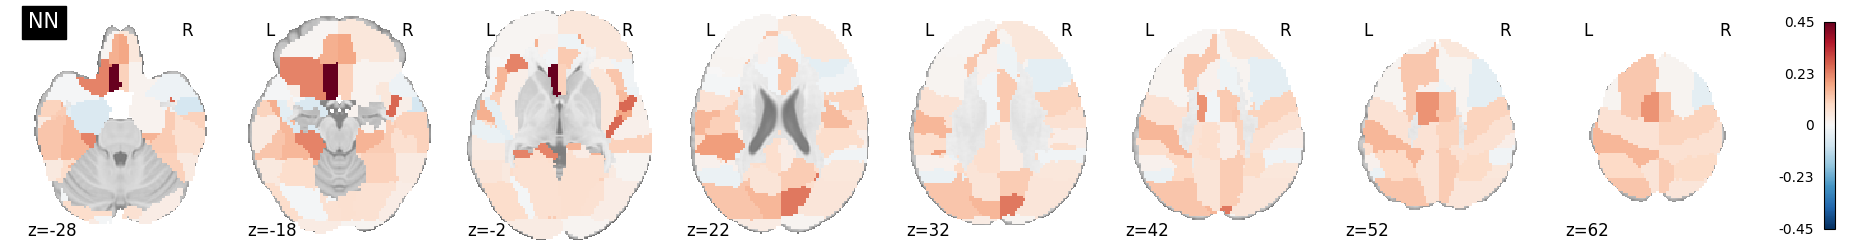

/Users/gracer/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/gracer/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


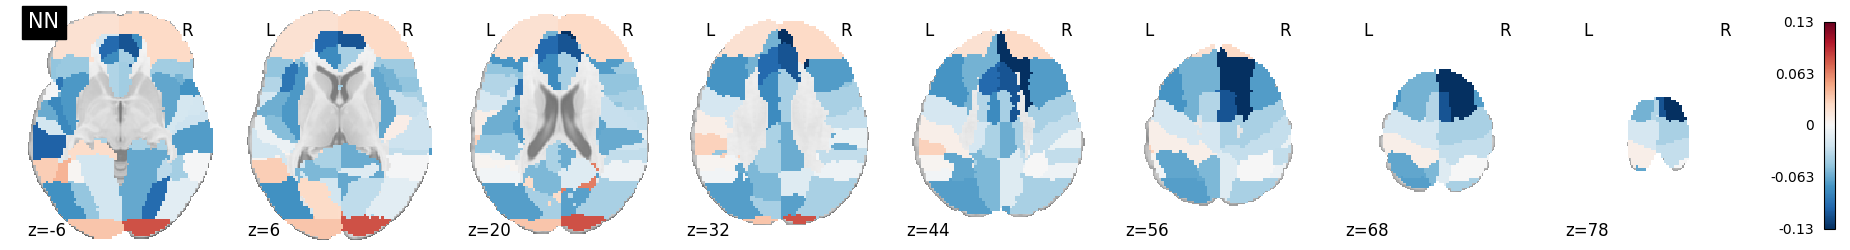

/Users/gracer/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/gracer/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/gracer/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/gracer/opt/anaconda3/lib/python3.8/site-pac

In [352]:
BRO_brain = roi_to_brain(pd.Series(BRO), expand_mask(mask))
PLA_brain = roi_to_brain(pd.Series(PLA), expand_mask(mask))

plot_stat_map(BRO_brain.to_nifti(), display_mode='z', cut_coords=8,  title = "NN", cmap='RdBu_r')
plot_stat_map(PLA_brain.to_nifti(), display_mode='z', cut_coords=8,  title = "NN", cmap='RdBu_r')
